## Uber Challenge

### Question 3 - Modeling

Uber’s Driver team is interested in predicting which driver signups are most likely to start driving.
To help explore this question, we have provided a sample dataset of a cohort of driver signups.
The data was pulled a some time after they signed up to include the result of whether they
actually completed their first trip. It also includes several pieces of background information
gathered about the driver and their car.
We would like you to use this data set to help understand what factors are best at predicting
whether a signup will start to drive within 30 days of signing up, and offer suggestions to
operationalize those insights to help Uber.
See below for a description of the dataset. Please include any code you wrote for the analysis
and delete the dataset when you have finished with the challenge. Please also call out any data
related assumptions or issues that you encounter.


### Part A
Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this
analysis (a few sentences/plots describing your approach will suffice). What fraction of the driver
signups took a first trip within 30 days of signing up?

### Part B
Build a predictive model to help Uber determine whether or not a driver signup will start driving
within 30 days of signing up. Discuss why you chose your approach, what alternatives you
considered, and any concerns you have. How valid is your model? Include any key indicators of
model performance.

### Part C
Briefly discuss how Uber might leverage the insights gained from the model to generate more
first trips (again, a few ideas/sentences will suffice).

#### Data set description
- id: driver_id
- city_name : city that this user signed up in
- signup_os : signup device of the user
- signup_channel : what channel did the driver sign up from
- signup_timestamp : timestamp of account creation
- bgc_date : timestamp when driver consented to background check
- vehicle_added_date : timestamp when driver’s vehicle information was uploaded
- vehicle_make: make of vehicle uploaded
- vehicle_model: model of vehicle uploaded
- vehicle_year: year that the car was made
- first_trip_date : timestamp of the first trip as a driver

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score

In [2]:
df=pd.read_csv('Product PA and DS Dataset.csv')
print(df.shape)
df.head()

(12357, 11)


,id,city_name,signup_os,signup_channel,signup_timestamp,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_trip_timestamp
0,082befb0-c1de-4c14-8700-94a7943a7545,Strark,NaN,R2D,2017-07-06T20:42:17Z,NaN,2017-07-06T20:42:56Z,Volkswagen,CC,2012,NaN
1,1ae6156f-63fc-40cf-9734-0995978c4b6e,Berton,ios web,Dost,2017-07-03T17:41:07Z,2017-07-03T17:42:06Z,2017-07-03T17:41:14Z,Toyota,4Runner,2003,2017-07-23T00:26:50Z
2,2a4a4eef-14ef-4ceb-82eb-66f1f7d0d219,Berton,NaN,R2D,2017-07-10T22:55:29Z,NaN,2017-07-11T17:44:44Z,Hyundai,Elantra,2015,NaN
3,56fe7597-3ad8-4798-8be8-5fbc4e2d3151,Berton,ios web,Referral,2017-07-27T18:27:21Z,2017-07-27T18:31:43Z,2017-07-27T18:31:09Z,Honda,Civic,2017,2017-07-31T04:07:24Z
4,67370341-68a5-415f-acf2-be58832a8f9c,Wrouver,other,Referral,2017-07-17T22:20:35Z,2017-07-17T22:21:09Z,2017-07-17T22:20:53Z,Honda,Accord,1999,NaN


In [3]:
print("There are {} observations and {} features in this dataset. \n".format(df.shape[0],df.shape[1]))

There are 12357 observations and 11 features in this dataset. 



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12357 entries, 0 to 12356
Data columns (total 11 columns):
id                                12357 non-null object
city_name                         12357 non-null object
signup_os                         6953 non-null object
signup_channel                    11143 non-null object
signup_timestamp                  11194 non-null object
bgc_date                          7803 non-null object
vehicle_added_date                11121 non-null object
vehicle_make                      11727 non-null object
vehicle_model                     12357 non-null object
vehicle_year                      12357 non-null int64
first_completed_trip_timestamp    6790 non-null object
dtypes: int64(1), object(10)
memory usage: 1.0+ MB


### Part A: Data Cleaning, Exploratory data analysis and Visualization


** Drop the rows without signup timestamp. Dropping the duplicate rows.**

In [5]:
df.drop_duplicates(inplace=True)
print('Number of duplicated rows:', 12357-df.shape[0])

Number of duplicated rows: 379


In [6]:
NaNTime=list(df[df['signup_timestamp'].isnull()==True].index)
df.drop(NaNTime,inplace=True)
print('Number of rows without signup timestamp:',12357-379-df.shape[0])
print(df.shape)

Number of rows without signup timestamp: 1155
(10823, 11)


In [7]:
df.id.nunique()

10601

In [8]:
print('Number of duplicated id and same signup_timestamp:',len(df[df[['id','signup_timestamp']].duplicated()]['id']))

Number of duplicated id and same signup_timestamp: 222


In [9]:
df.drop_duplicates(subset=['id','signup_timestamp'],inplace=True)
df.shape

(10601, 11)

#### If for an observation a background date is not provided, change it to its signup_timestamp.

In [10]:
df.loc[df['bgc_date'].isnull(),'bgc_date']=df[df['bgc_date'].isnull()]['signup_timestamp']

#### If for an observation the vehicle added date is not provided, change it to its bgc_date.

In [11]:
df.loc[df['vehicle_added_date'].isnull(),'vehicle_added_date']=df[df['vehicle_added_date'].isnull()]['signup_timestamp']

#### Change columns with time provided information to pandas datetime format.

In [12]:
df['signup_timestamp']=pd.to_datetime(df['signup_timestamp'])
df['vehicle_added_date']=pd.to_datetime(df['vehicle_added_date'])
df['bgc_date']=pd.to_datetime(df['bgc_date'])
df['first_completed_trip_timestamp']=pd.to_datetime(df['first_completed_trip_timestamp'])

In [13]:
print('years of registeration:',list(df.signup_timestamp.dt.year.unique()))
print('months of registeration:',list(df.signup_timestamp.dt.month.unique()))

years of registeration: [2017]
months of registeration: [7]


#### All the registerations were on July 2017.

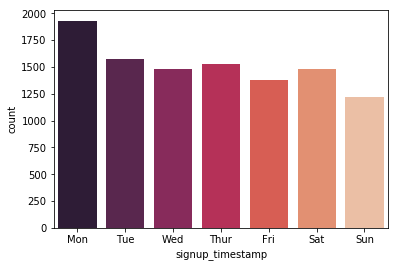

In [14]:
a=sns.countplot(df.signup_timestamp.dt.dayofweek,palette="rocket")
a.set_xticklabels(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
plt.show()

#### The registerations happened mostly on Monday.

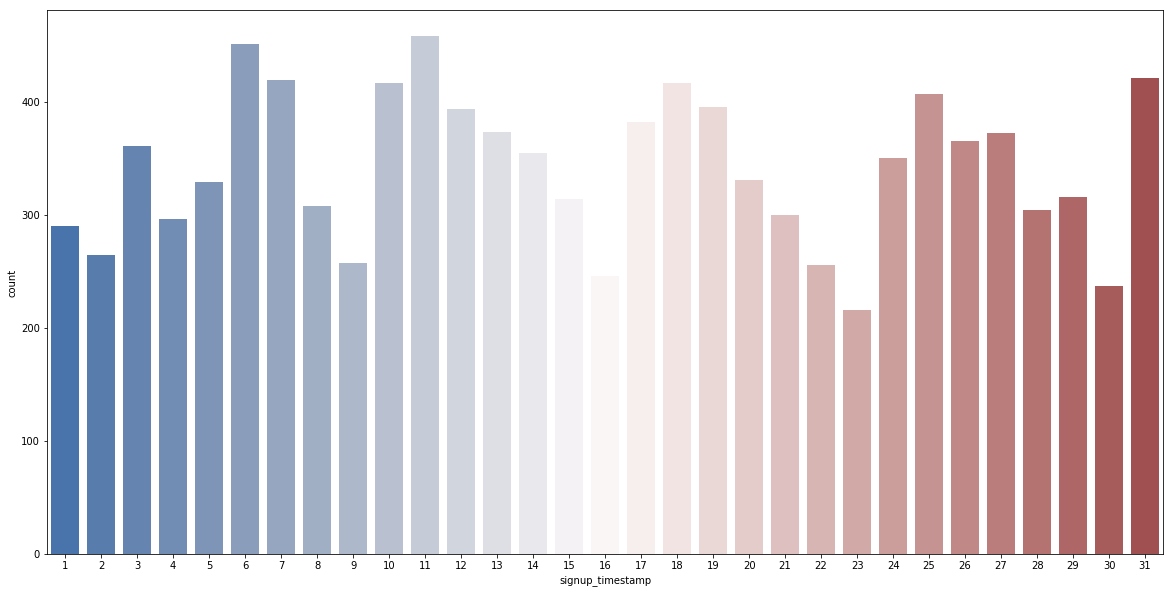

In [15]:
plt.figure(figsize=(20,10))
sns.countplot(df.signup_timestamp.dt.day,palette="vlag")
plt.show()

#### There is not any special trend in the above plot. (Number of registerations on each day of the month.)

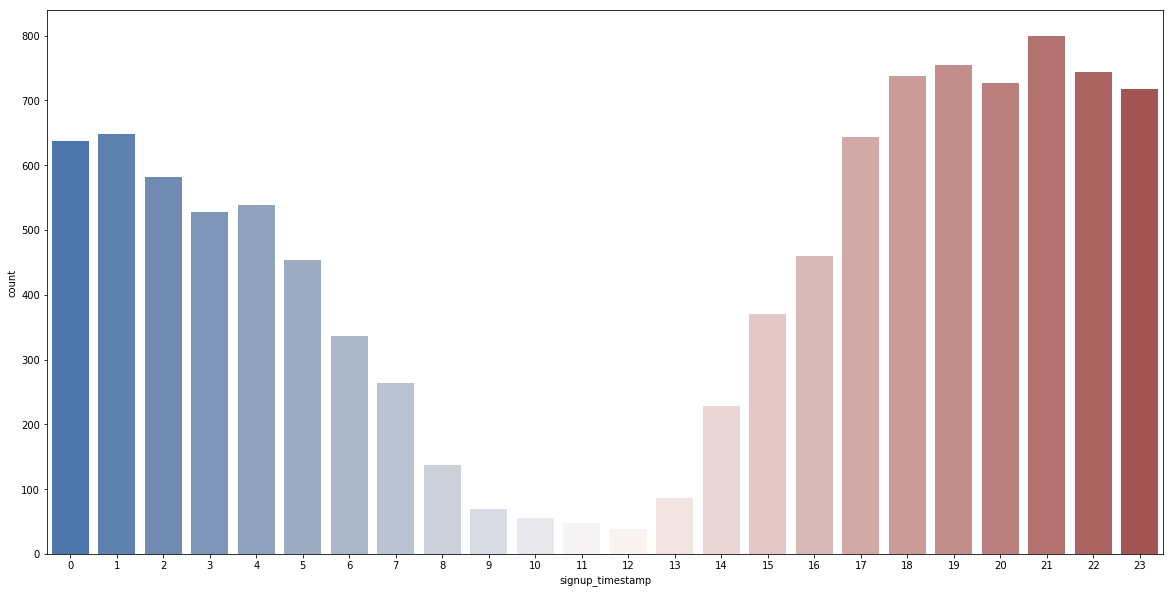

In [16]:
plt.figure(figsize=(20,10))
sns.countplot(df.signup_timestamp.dt.hour,palette="vlag")
plt.show()

#### It is interesting that most signups have happened in non-working hours.

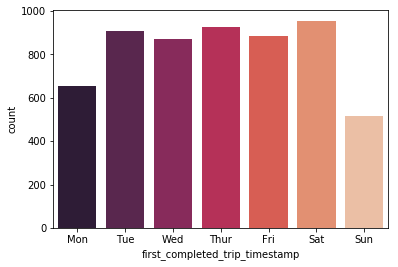

In [17]:
a=sns.countplot(df.first_completed_trip_timestamp.dt.dayofweek,palette="rocket")
a.set_xticklabels(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
plt.show()

#### The above plot shows the weekly trend for the first completed trip timestamp.

### Countplot for the city that user signed up

Strark     5928
Berton     3265
Wrouver    1408
Name: city_name, dtype: int64


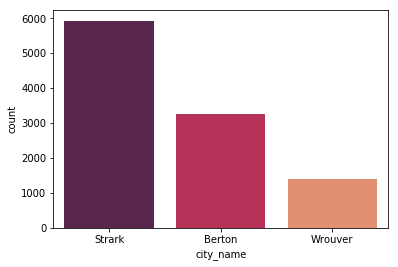

In [18]:
print(df['city_name'].value_counts())
sns.countplot(df['city_name'],palette="rocket")
plt.show()

In [19]:
print(sum(df['city_name']=='Strark')/len(df['city_name']))
print(sum(df['city_name']=='Berton')/len(df['city_name']))
print(sum(df['city_name']=='Wrouver')/len(df['city_name']))

0.5591925290066975
0.3079898122818602
0.13281765871144233


#### 56% signed up in Strak city, 31% in Berton, and 13% in Wrouver.

In [20]:
LenSign=sum(df['signup_timestamp'].notnull()) #total number of drivers with signup_timestamp
print('Fraction of the drivers who have their first trip within 30 days:',
(sum(((df['first_completed_trip_timestamp']-df['signup_timestamp']).dt.days)<30)/LenSign)*100,'%')

Fraction of the drivers who have their first trip within 30 days: 53.6741816809735 %


###  <span style="color:salmon"> Around 53.67% of the drivers have started their trip within 30 days.

### Countplot for signup device of the user

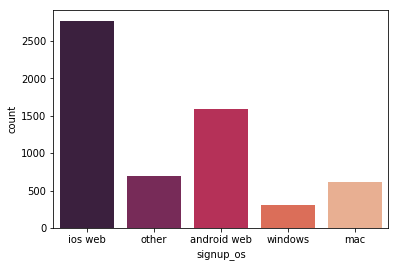

Percent of missing values: 43.70342420526365


In [21]:
sns.countplot(df['signup_os'],palette="rocket")
plt.show()
print('Percent of missing values:',sum(df['signup_os'].isnull())/len(df['signup_os'])*100)

#### More than 43.7% of the signup device of the user is missing. I have to figure out is it worthy to keep this column or not. But for now I just fill the NaN values with 'ios web'.

In [22]:
df['signup_os'].fillna('ios Web', inplace=True)

### Countplot for signup_channel

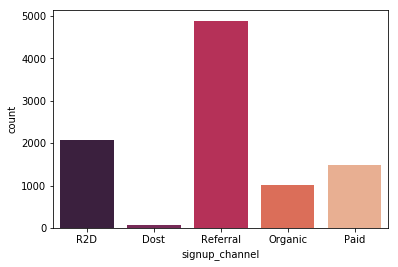

Percent of missing values: 9.89529289689652


In [23]:
sns.countplot(df['signup_channel'],palette="rocket")
plt.show()
print('Percent of missing values:',sum(df['signup_channel'].isnull())/len(df['signup_channel'])*100)

In [24]:
df['signup_channel'].fillna('Referral', inplace=True)

#### Around 10% of the signup_channel is missing, I filled the NaN values with the most popular category which is 'Referral'.

### Countplot for the vehicle make 

Number of Unique type of vehicles: 47


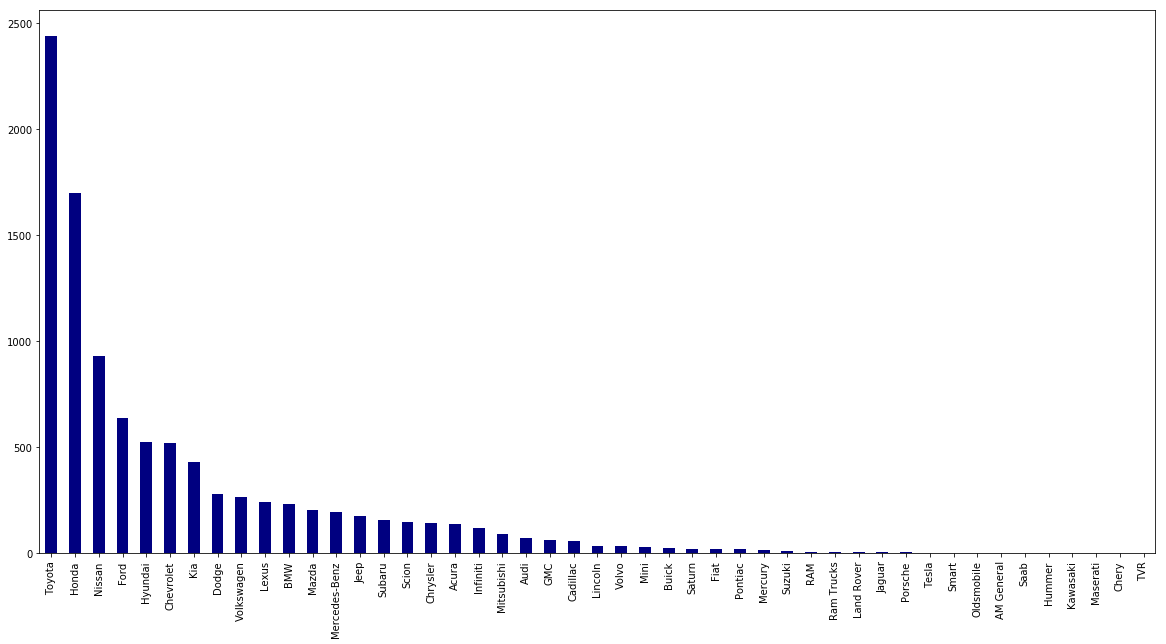

Percent of missing values: 5.065559852844071


In [25]:
print('Number of Unique type of vehicles:',df['vehicle_make'].nunique())
plt.figure(figsize=(20,10))
df['vehicle_make'].value_counts().plot(kind='bar',color='Navy')
plt.show()
print('Percent of missing values:',sum(df['vehicle_make'].isnull())/len(df['vehicle_make'])*100)

In [26]:
df['vehicle_make'].fillna('Toyota', inplace=True)

#### I fill the 5% NaN values of this column with 'Toyota' which is the most popular one.

In [27]:
print('Total number of unique vehicle models:',df['vehicle_model'].nunique())
print('Percent of missing values:',sum(df['vehicle_model'].isnull())/len(df['vehicle_model'])*100) #no missing values

Total number of unique vehicle models: 473
Percent of missing values: 0.0


#### 473 unique vehicle models are presented.

### Histogram of the vehicle year

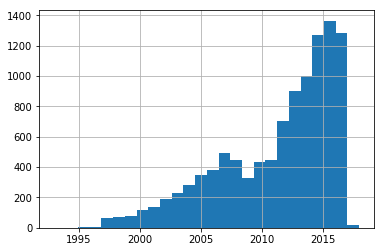

In [28]:
df['vehicle_year'].hist(bins=26)
plt.show()

In [29]:
print('Total number of unique vehicle year:',df['vehicle_year'].nunique())
print('Percent of missing values:',sum(df['vehicle_year'].isnull())/len(df['vehicle_year'])*100) #no missing values

Total number of unique vehicle year: 26
Percent of missing values: 0.0


#### Most vehicles were made between the years 2014 to 2016.

### Part B
Build a predictive model to help Uber determine whether or not a driver signup will start driving
within 30 days of signing up. Discuss why you chose your approach, what alternatives you
considered, and any concerns you have. How valid is your model? Include any key indicators of
model performance.

#### Steps:
####  <span style="color:darkblue"> 1. First I make a 'Target' columns. If the trip happens within 30 days the Target=1, otherwise it is 0.

In [30]:
y=(((df['first_completed_trip_timestamp']-df['signup_timestamp']).dt.days)<30)*1
y.value_counts()

1    5690
0    4911
dtype: int64

#### The target values are almost balanced.  

####  <span style="color:darkblue"> 2. Change the dummy variables to integers. 

In [31]:
X=pd.DataFrame()
dict0={'Strark':0, 'Berton':1, 'Wrouver':2}
X['city_name']=df['city_name'].map(dict0)

dict1={'R2D':0,'Dost':1,'Referral':2,'Organic':3,'Paid':4}
X['signup_channel']=df['signup_channel'].map(dict1)

df.vehicle_make = pd.Categorical(df.vehicle_make)
X['vehicle_make_code'] = df.vehicle_make.cat.codes

df.vehicle_model = pd.Categorical(df.vehicle_model)
X['vehicle_model_code'] = df.vehicle_model.cat.codes

In [32]:
X.describe()

,city_name,signup_channel,vehicle_make_code,vehicle_model_code
count,10601.000000,10601.000000,10601.000000,10601.000000
mean,0.573625,1.979813,25.365626,200.097727
std,0.714327,1.203363,14.774413,132.260472
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,13.000000,88.000000
50%,0.000000,2.000000,22.000000,168.000000
75%,1.000000,2.000000,44.000000,303.000000
max,2.000000,4.000000,46.000000,472.000000


 #### <span style="color:darkblue">3- Create two time columns:
- time1 which is the time difference in seconds between the background check and the signup.
- time2 which is the time differece in seconds between the background check and the vehicle added date.

In [33]:
X['Day']=(df['signup_timestamp']).dt.day
X['Weekday']=(df['signup_timestamp']).dt.dayofweek
X['Hour']=(df['signup_timestamp']).dt.hour

X['time1']=(df['bgc_date']-df['signup_timestamp']).dt.seconds
X['time2']=(df['signup_timestamp']-df['vehicle_added_date']).dt.seconds

In [34]:
X.head()

,city_name,signup_channel,vehicle_make_code,vehicle_model_code,Day,Weekday,Hour,time1,time2
0,0,0,45,69,6,3,20,0,86361
1,1,1,44,11,3,0,17,59,86393
2,1,0,15,139,10,0,22,0,18645
3,1,2,13,101,27,3,18,262,86172
4,2,2,13,34,17,0,22,34,86382


 #### <span style="color:darkblue">4- Splitting the data to train and test, normalizing the data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=55)

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test) 

 #### <span style="color:darkblue"> 5- Start with Logstic Regression

In [36]:
LogClassifier= LogisticRegression()
LogClassifier.fit(X_train, y_train)
y_pred=LogClassifier.predict(X_test)
y_pred_prob=LogClassifier.predict_proba(X_test)[:, 1]


print('Correct accuracy of the train set with Logistic Regression is:', round(LogClassifier.score(X_train,y_train)*100,4),'%')
print('Correct accuracy of the test set with Logistic Regression is:', round(LogClassifier.score(X_test,y_test)*100,4),'%')
print('')
start=time.time()
LogScores = cross_val_score(LogClassifier, X, y, cv=10)
end=time.time()
print('Logistic Regression score mean with cross val is:',round(np.mean(LogScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')
print('')
print('Confusion Matrix is:')
print(confusion_matrix(y_test, y_pred))
print('')
print('Logistic Regression log_loss is:',round(log_loss(y_test, y_pred),4))

average_precision = average_precision_score(y_test, y_pred)
print('')
print('Average precision-recall score: {0:0.4f}'.format(average_precision))

Correct accuracy of the train set with Logistic Regression is: 54.3042 %
Correct accuracy of the test set with Logistic Regression is: 55.9642 %

Logistic Regression score mean with cross val is: 54.1741 %
Total elapsed time is: 1.9729  sec

Confusion Matrix is:
[[  73  868]
 [  66 1114]]

Logistic Regression log_loss is: 15.2098

Average precision-recall score: 0.5617


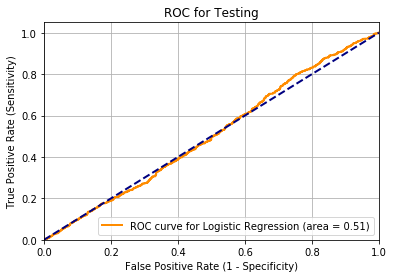

In [37]:
fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve for Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],lw=lw, color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC for Testing')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### I looks like that we do not have enough obeservations to make a good prediction model with Logistic Regression. Even the train accuracy is less than the test accuracy, and the model is underfitted.  The AUC is also 0.51 which is very low. But lets try other nonlinear models.

 #### <span style="color:darkblue"> 6- Check RandomForest

In [38]:
RandClassifier= RandomForestClassifier()
RandClassifier.fit(X_train, y_train)
y_pred=RandClassifier.predict(X_test)
y_pred_prob=RandClassifier.predict_proba(X_test)[:, 1]


print('Correct accuracy of the train set with Random Forest Classifier is:', round(RandClassifier.score(X_train,y_train)*100,4),'%')
print('Correct accuracy of the test set with Random Forest Classifier is:', round(RandClassifier.score(X_test,y_test)*100,4),'%')
print('')
start=time.time()
RandScores = cross_val_score(RandClassifier, X, y, cv=10)
end=time.time()
print('Random Forest score mean with cross val is:',round(np.mean(RandScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')
print('')
print('Confusion Matrix is:')
print(confusion_matrix(y_test, y_pred))
print('')
print('Random Forest log_loss is:',round(log_loss(y_test, y_pred),4))
average_precision = average_precision_score(y_test, y_pred)
print('')
print('Average precision-recall score: {0:0.4f}'.format(average_precision))

Correct accuracy of the train set with Random Forest Classifier is: 98.5142 %
Correct accuracy of the test set with Random Forest Classifier is: 51.8623 %

Random Forest score mean with cross val is: 52.0706 %
Total elapsed time is: 5.2361  sec

Confusion Matrix is:
[[523 418]
 [603 577]]

Random Forest log_loss is: 16.6263

Average precision-recall score: 0.5679


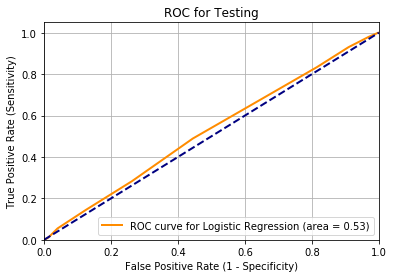

In [39]:
fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve for Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],lw=lw, color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC for Testing')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Random forest is overfitted. We have a hight training accuracy but very low test accuracy. The AUC is also very low. Now I try different max_depth and min_samples_leaf to overcome the overfitting.

- n_estimators: In general the more trees the less likely the algorithm is to overfit. The lower this number, the closer the model is to a decision tree, with a restricted feature set.

- max_depth: Larger number will reduce the complexity of the learned models, lowering over fitting risk.

- min_samples_leaf: This has a similar effect to the max_depth parameter, it means the branch will stop splitting once the leaves have that number of samples each.

In [40]:
RandClassifier= RandomForestClassifier(n_estimators=10,max_depth=10,min_samples_leaf=10,random_state=0)
RandClassifier.fit(X_train, y_train)
y_pred=RandClassifier.predict(X_test)
y_pred_prob=RandClassifier.predict_proba(X_test)[:, 1]

print('Correct accuracy of the train set with Random Forest Classifier is:', round(RandClassifier.score(X_train,y_train)*100,4),'%')
print('Correct accuracy of the test set with Random Forest Classifier is:', round(RandClassifier.score(X_test,y_test)*100,4),'%')
print('')
start=time.time()
RandScores = cross_val_score(RandClassifier, X, y, cv=10)
end=time.time()
print('Random Forest score Mean with cross val is:',round(np.mean(RandScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')
print('')
print('Confusion Matrix is:')
print(confusion_matrix(y_test, y_pred))
print('')
print('Random Forest log_loss is:',round(log_loss(y_test, y_pred),4))
average_precision = average_precision_score(y_test, y_pred)
print('')
print('Average precision-recall score: {0:0.4f}'.format(average_precision))

Correct accuracy of the train set with Random Forest Classifier is: 67.4175 %
Correct accuracy of the test set with Random Forest Classifier is: 55.7756 %

Random Forest score Mean with cross val is: 55.7118 %
Total elapsed time is: 2.6921  sec

Confusion Matrix is:
[[361 580]
 [358 822]]

Random Forest log_loss is: 15.2748

Average precision-recall score: 0.5772


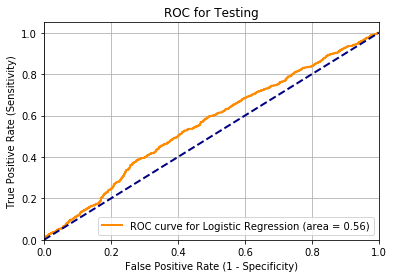

In [41]:
fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve for Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],lw=lw, color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC for Testing')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### The model is now underfitted with the new variables and the AUC is still very low. I try Gradient Bootstrapping technique which is more robust than Random Forest.

 #### <span style="color:darkblue">  7- Try Gradient boosting classifier.

In [42]:
GradClassifier = GradientBoostingClassifier()
GradClassifier.fit(X_train, y_train)
y_pred=GradClassifier.predict(X_test)
y_pred_prob=GradClassifier.predict_proba(X_test)[:, 1]

print('Correct accuracy of the train set with Gradient Boosting Classifier is:', round(GradClassifier.score(X_train,y_train)*100,4),'%')
print('Correct accuracy of the test set with Gradient Boosting Classifier is:', round(GradClassifier.score(X_test,y_test)*100,4),'%')
print('')
start=time.time()
GradScores = cross_val_score(GradClassifier, X, y, cv=10)
end=time.time()
print('Gradient boosting score Mean with cross val is:',round(np.mean(GradScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')
print('')
print('Confusion Matrix is:')
print(confusion_matrix(y_test, y_pred))
print('')
print('GradClassifier log_loss is:',round(log_loss(y_test, y_pred),4))
average_precision = average_precision_score(y_test, y_pred)
print('')
average_precision = average_precision_score(y_test, y_pred)
print('Average precision-recall score: {0:0.4f}'.format(average_precision))


Correct accuracy of the train set with Gradient Boosting Classifier is: 62.8066 %
Correct accuracy of the test set with Gradient Boosting Classifier is: 56.8128 %

Gradient boosting score Mean with cross val is: 56.7965 %
Total elapsed time is: 7.8506  sec

Confusion Matrix is:
[[365 576]
 [340 840]]

GradClassifier log_loss is: 14.9165

Average precision-recall score: 0.5826


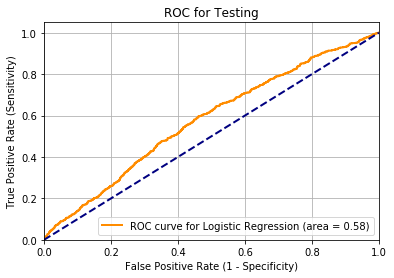

In [43]:
fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve for Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],lw=lw, color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC for Testing')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### We have the same problem as we had with previous classifiers. I try KNN and SVM next.

 #### <span style="color:darkblue">  8- Try KNN classifier

In [44]:
KnnClassifier=KNeighborsClassifier()
KnnClassifier.fit(X_train, y_train)
y_pred=KnnClassifier.predict(X_test)
y_pred_prob=KnnClassifier.predict_proba(X_test)[:, 1]

print('Correct accuracy with KNN Classifier is:', round(KnnClassifier.score(X_train,y_train)*100,4),'%')
print('Correct accuracy with KNN Classifier is:', round(KnnClassifier.score(X_test,y_test)*100,4),'%')
print('')
start=time.time()
KnnScores = cross_val_score(KnnClassifier, X, y, cv=10)
end=time.time()
print('KNN score Mean with cross val is:',round(np.mean(KnnScores)*100,4),'%')
print('Total elapsed time is:', round(end-start,4),' sec')
print('')
print('Confusion Matrix is:')
print(confusion_matrix(y_test, y_pred))
print('')
print('KnnClassifier log_loss is:',round(log_loss(y_test, y_pred),4))
print('')
average_precision = average_precision_score(y_test, y_pred)
print('Average precision-recall score: {0:0.4f}'.format(average_precision))

Correct accuracy with KNN Classifier is: 69.8939 %
Correct accuracy with KNN Classifier is: 51.5323 %

KNN score Mean with cross val is: 50.4103 %
Total elapsed time is: 0.4372  sec

Confusion Matrix is:
[[405 536]
 [492 688]]

KnnClassifier log_loss is: 16.7404

Average precision-recall score: 0.5597


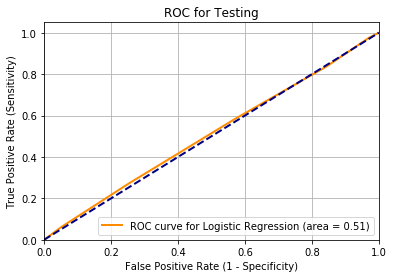

In [45]:
fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve for Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],lw=lw, color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC for Testing')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### KNN is not a good solution as well.

 #### <span style="color:darkblue">  8- Try SVM

In [46]:
SVM=svm.SVC(kernel='rbf',gamma=.1,C=100)
SVM.fit(X_train, y_train)  
y_pred=SVM.predict(X_test)

print('Correct accuracy of the train set with SVM Classifier is:', round(SVM.score(X_train,y_train)*100,4),'%')
print('Correct accuracy of the test set with SVM Classifier is:', round(SVM.score(X_test,y_test)*100,4),'%')
print('')
print('Confusion Matrix is:')
print(confusion_matrix(y_test, y_pred))
print('')
print('SVM log_loss is:',round(log_loss(y_test, y_pred),4))
print('')
average_precision = average_precision_score(y_test, y_pred)
print('Average precision-recall score: {0:0.4f}'.format(average_precision))

Correct accuracy of the train set with SVM Classifier is: 69.1156 %
Correct accuracy of the test set with SVM Classifier is: 53.5596 %

Confusion Matrix is:
[[342 599]
 [386 794]]

SVM log_loss is: 16.0402

Average precision-recall score: 0.5655


#### The correct accuracy is higher with SVM comparing with other classification techniques. However SVM is slower, and the parameters of the RBF Kernel needs to be tuned.

 #### <span style="color:darkblue">I faced a high bias in all classifiers. High Bias emerges when the model is under fitted to the underlying data and we have a high error in both the train and test set. And as it is shown, all models provide very close AUC score (low value), log_loss score (high value), and precision_recall score. Which ensure us about the lack of information and observation. The best solution is increasing the number of input features and also the number of observations. In other words, we need a bigger dataset to make a good prediction.

### Part C
*Briefly discuss how Uber might leverage the insights gained from the model to generate more first trips (again, a few ideas/sentences will suffice).*
    



 #### <span style="color:darkblue"> Since the data did not have enough observation and features I could not provide a good model predictive model. However, I give some ideas that I think may leverage the insights:
    
<span style="color:darkblue">1- Uber can add more information of each driver: age, gender, race, other sources of income, mileage on the vehicle, color of the vehicle, ... . In this case, providing a good predictive model would be easier as well.

<span style="color:darkblue">2- Uber can focus to process the clearance of each driver faster.

 <span style="color:darkblue">3- Uber can follow up through the signup channel to see why the drivers who has registered have not started their trip yet.

 <span style="color:darkblue">4- Uber can provide promotions. For example Uber can offer more payment to drivers who start their first trip in less than a week.



